In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [3]:
#df = pd.read_csv('balanced_transformed_data.csv', index_col=0)
df = pd.read_csv('Transform_data.csv', index_col = 0)
df.info()
df.loc[:].fillna(0, inplace =True)

<class 'pandas.core.frame.DataFrame'>
Index: 13254 entries, 0 to 15488
Columns: 544 entries, Rank to noitaminA
dtypes: float64(543), int64(1)
memory usage: 55.1 MB


# Split and Train Data

In [4]:
X = df.drop('Target', axis = 1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 2)

print(y_train.value_counts())
y_test.value_counts()

Target
0    10471
1      132
Name: count, dtype: int64


Target
0    2603
1      48
Name: count, dtype: int64

# Baseline

In [6]:
mean_y_train = np.mean(y_train)

class MeanPredictor:
    def fit(self, X,y):
        self.mean = np.mean(y)
        
    def predict(self, X):
        return np.full(shape=(len(X),), fill_value = self.mean)

model = MeanPredictor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)

print(mean_y_train, mae)

0.012449306799962276 0.03010485811916394


# Pipeline

In [13]:
#Pipe = Pipeline([('Reg', LogisticRegression()), ('dtc', DecisionTreeClassifier())])

#Pipe.fit(X_train, y_train)

# Logistic Regression

   Iteration     Score
0       1000  0.981894
1       1500  0.981894
2       2000  0.981894
3       2500  0.981894
0.981893625047152
[[2603    0]
 [  48    0]]


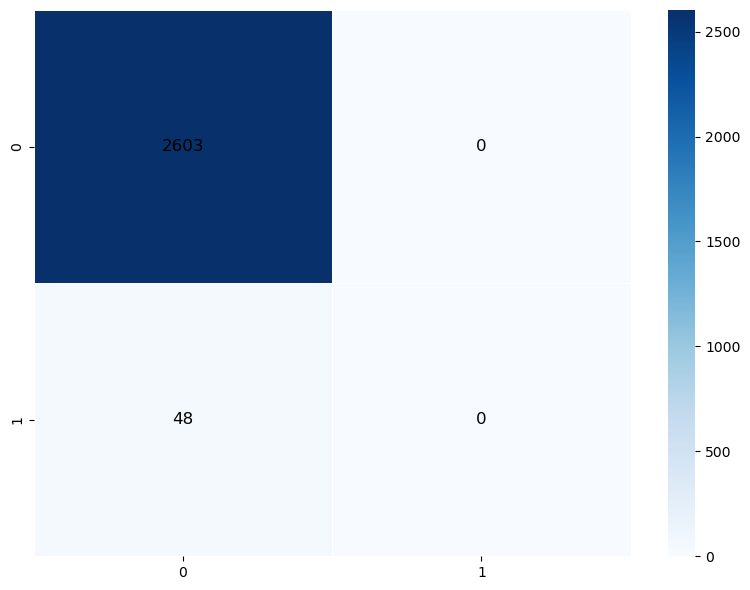

In [30]:
#Create a log model and fit it
log = LogisticRegression(multi_class = 'ovr').fit(X_train, y_train)


#Retrieve multiple scores for Max iteration
scores = []
for itr in range(1000,3000, 500):
    
    log = LogisticRegression(multi_class = 'ovr',max_iter = itr).fit(X_train, y_train)
    scores.append([itr, log.score(X_test,y_test)])

#Create a Dataframe for the results 
df_log = pd.DataFrame(scores, columns = ['Iteration', 'Score'])
print(df_log)

#Assumed best hyperparameter setting score
log = LogisticRegression(multi_class = 'ovr',max_iter = 100).fit(X_train, y_train)
log_score = log.score(X_test, y_test)
print(log_score)


#Visualize a confusion Matrix
log_y_pred = log.predict(X_test)
cm = confusion_matrix(y_test, log_y_pred)
print(cm)
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', linewidths=.5)

#Manually annotate the confusion matrix scores as the Annot parameter does not display correctly
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j + 0.5, i + 0.5, cm[i, j],
                ha='center', va='center', color='black', fontsize=12)
plt.tight_layout()
plt.show()

# Decision Tree

   depth  depth_score  leaf_score
0      1     0.981894         NaN
1      2     0.981516    0.981894
2      3     0.981139         NaN
3      4     0.981139    0.981516
4      5     0.980385         NaN
5      6     0.981139    0.981139
6      8          NaN    0.981139
7     10          NaN    0.980762
8     12          NaN    0.980762
[[2600    3]
 [  48    0]]


[Text(0.5, 0.9375, 'x[0] <= -1.548\ngini = 0.025\nsamples = 10603\nvalue = [10471, 132]'),
 Text(0.26666666666666666, 0.8125, 'x[448] <= 0.5\ngini = 0.178\nsamples = 283\nvalue = [255, 28]'),
 Text(0.2, 0.6875, 'x[6] <= 0.5\ngini = 0.168\nsamples = 280\nvalue = [254, 26]'),
 Text(0.13333333333333333, 0.5625, 'gini = 0.035\nsamples = 112\nvalue = [110, 2]'),
 Text(0.26666666666666666, 0.5625, 'x[141] <= 0.5\ngini = 0.245\nsamples = 168\nvalue = [144, 24]'),
 Text(0.2, 0.4375, 'x[481] <= 0.5\ngini = 0.178\nsamples = 132\nvalue = [119, 13]'),
 Text(0.13333333333333333, 0.3125, 'x[302] <= 0.5\ngini = 0.156\nsamples = 129\nvalue = [118, 11]'),
 Text(0.06666666666666667, 0.1875, 'gini = 0.123\nsamples = 122\nvalue = [114, 8]'),
 Text(0.2, 0.1875, 'x[256] <= 0.5\ngini = 0.49\nsamples = 7\nvalue = [4, 3]'),
 Text(0.13333333333333333, 0.0625, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.26666666666666666, 0.0625, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.26666666666666666, 0.3

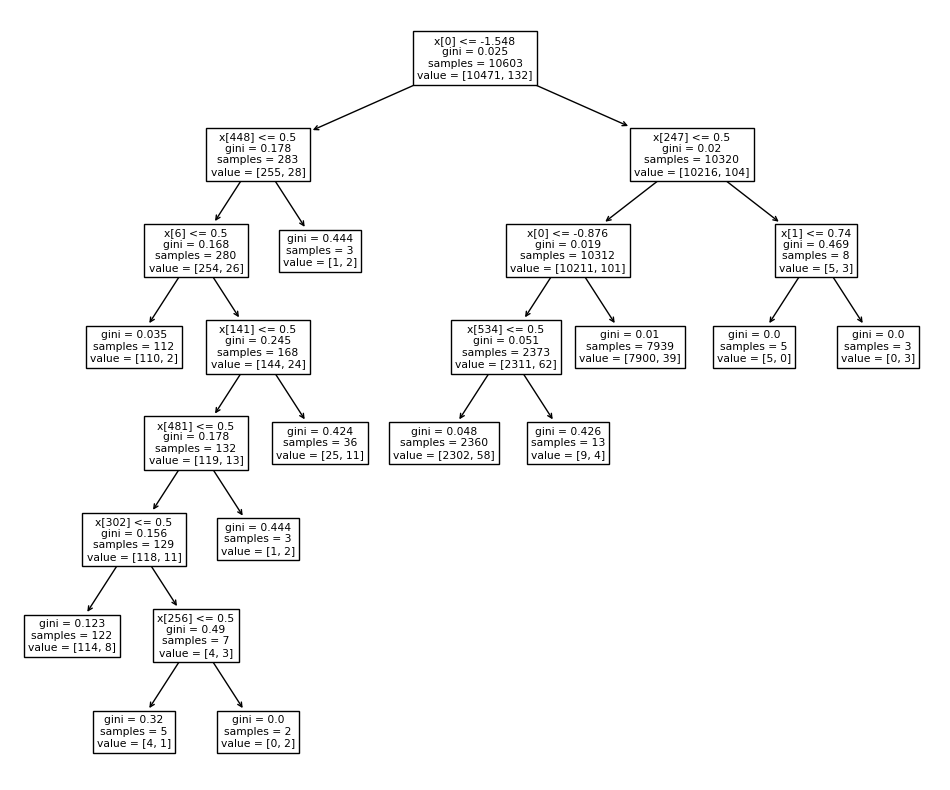

In [19]:
scores = []
leafnodes = []

for depth in range(1,7):
    #Get multiple max_depth Scores
    clf_dt = DecisionTreeClassifier(max_depth = depth, random_state=2).fit(X_train, y_train)
    scores.append([depth, clf_dt.score(X_test,y_test)])
    
    #Get multiple max_leaf_nodes scores
    clf_dt = DecisionTreeClassifier(max_leaf_nodes = depth*2, random_state=2).fit(X_train, y_train)
    leafnodes.append([depth*2, clf_dt.score(X_test,y_test)])
    

#Join both max_depth and leaf_node scores into one DataFrame
df_dt = pd.DataFrame(scores, columns = ['depth', 'depth_score'])
df_dt_leaf = pd.DataFrame(leafnodes, columns = ['depth', 'leaf_score'])
#Note: pd.mergeordered() would also work
df_dt = df_dt.merge(df_dt_leaf, how = 'outer', on = 'depth')
print(df_dt)

#Perceived best Parameter
clf_dt = DecisionTreeClassifier(max_leaf_nodes = 12, random_state=2).fit(X_train, y_train)
clf_dt_score = clf_dt.score(X_test,y_test)


clf_dt = DecisionTreeClassifier(max_leaf_nodes = 12, random_state=2).fit(X_train, y_train)
dt_pred = clf_dt.predict(X_test)
cm = confusion_matrix(y_test, dt_pred)
print(cm)


#Plot tree
plt.figure(figsize = (12,10))
plot_tree(clf_dt)


# Random Forest Classifier

In [18]:
rfc = RandomForestClassifier().fit(X_train, y_train)

#View most important features by algorithm
importance_df = pd.DataFrame({'Features': df.columns.drop('Target'), 'Importance': rfc.feature_importances_})
importance_df.sort_values('Importance', ascending = False)
print(importance_df.head(15))



#Generate multiple scores on different hyperparameters
scores = []
for estimate in range(1,20):
    #
    rfc = RandomForestClassifier(n_estimators = estimate, random_state=2).fit(X_train, y_train)
    scores.append([estimate, rfc.score(X_test,y_test)])

    
rfc_df = pd.DataFrame(scores, columns = ['Estimator', 'Score'])
rfc_df.sort_values('Score', inplace= True, ascending = False)
print(rfc_df)

#Perceived best hyperparameter
rfc = RandomForestClassifier(n_estimators = 8, random_state=2).fit(X_train, y_train)
rfc_score = rfc.score(X_test, y_test)

#Confusion Matrix
rfc = RandomForestClassifier(n_estimators =18, random_state=2).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, rfc_pred)
print(cm)

        Features  Importance
0           Rank    0.214734
1         Rating    0.146800
2          DVD S    0.002604
3          Movie    0.006357
4            OVA    0.011813
5          Other    0.002060
6             TV    0.019191
7          TV Sp    0.006047
8            Web    0.005311
9    Unnamed: 11    0.003655
10  15th Century    0.000029
11  16th Century    0.000006
12  17th Century    0.000067
13  18th Century    0.001035
14  19th Century    0.000083
    Estimator     Score
9          10  0.980385
17         18  0.980385
3           4  0.980385
16         17  0.980385
11         12  0.980385
12         13  0.980385
4           5  0.980008
5           6  0.980008
7           8  0.980008
8           9  0.980008
15         16  0.980008
10         11  0.980008
14         15  0.979630
18         19  0.979630
13         14  0.979630
6           7  0.979630
1           2  0.979253
2           3  0.978499
0           1  0.970200
[[2597    6]
 [  46    2]]


# ADA Boost Classifier

In [11]:
weak_learner = DecisionTreeClassifier(max_depth = 1)
clf_ada = AdaBoostClassifier(estimator= weak_learner, random_state= 2).fit(X_train, y_train)
clf_ada_score = clf_ada.score(X_test, y_test)
print(clf_ada_score)

importance_df = pd.DataFrame({'Features': df.columns.drop('Target'), 'Importance': clf_ada.feature_importances_})
importance_df.sort_values('Importance', ascending = False)
print(importance_df.head(15))

clf_ada_pred = clf_ada.predict(X_test)
cm = confusion_matrix(y_test, clf_ada_pred)
print(cm)

0.98113919275745
        Features  Importance
0           Rank        0.16
1         Rating        0.00
2          DVD S        0.02
3          Movie        0.02
4            OVA        0.00
5          Other        0.02
6             TV        0.02
7          TV Sp        0.00
8            Web        0.02
9    Unnamed: 11        0.00
10  15th Century        0.00
11  16th Century        0.00
12  17th Century        0.00
13  18th Century        0.00
14  19th Century        0.00
[[2601    2]
 [  48    0]]


# Best perceived accuracy score of each models

In [22]:
print(f' AdaBoost: {clf_ada_score} \n Random Forest: {rfc_score} \n Decision Tree: {clf_dt_score} \n \
Logistic Regression {log_score}')

 AdaBoost: 0.98113919275745 
 Random Forest: 0.980007544322897 
 Decision Tree: 0.980761976612599 
 Logistic Regression 0.981893625047152


# GridSearchCV

In [61]:
log_parameters = {'max_iter':[100,1000,3000,7000], 'multi_class': ['ovr']}
ada_parameters = {'estimator': [DecisionTreeClassifier(max_depth = 1),\
                                DecisionTreeClassifier(max_depth = 5)]}
rfc_parameters = {'n_estimators': np.arange(1,20)}
dt_parameters = {'max_depth': np.arange(1,20) , 'max_leaf_nodes': np.arange(1,50,2)}


gd = GridSearchCV(estimator = DecisionTreeClassifier(random_state =2), param_grid = dt_parameters,\
                 cv =5, n_jobs = 4).fit(X_train, y_train)

print(gd.best_params_)

{'max_depth': 1, 'max_leaf_nodes': 3}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
95 fits failed out of a total of 2375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py",

# RandomizedSearchCV

In [63]:
rs = RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state =2),\
                        param_distributions = dt_parameters,\
                 cv =5, n_jobs = 4, n_iter= 10, scoring = 'accuracy').fit(X_train, y_train)
print(rs.best_params_)

{'max_leaf_nodes': 49, 'max_depth': 1}


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", lin